 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 4. Tensorflow basis**
# Homework 1. optimizer 구현하기


### _Objective_
1. homework 목적



╚═══════════════════════════════════════════════╝


#### 함수 설명

로젠브록 함수(Rosenbrock function)는 수학적 최적화에서 최적화 알고리즘을 시험해볼 용도로 만든 비블록 함수 입니다.


로젠브록의 골짜기(Rosenbrock's valley) 또는 로젠브록 바나나 함수(Rosenbrock's banana function)라고도 합니다. 

함수식은 다음과 같습니다.


${\displaystyle f(x,y)=(1-x)^{2}+100(y-x^{2})^{2}}$

![Imgur](https://i.imgur.com/qMRFEAZ.png) 

In [0]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import numpy as np


def rosenbrock (x, y):
    return (1-x) ** 2 + 100*(y - x**2) ** 2


# start point : x:-3, y:-2 에서 시작합니다.  
start_x, start_y = -3., -2.
start_z = rosenbrock(start_x, start_y)
start_xy = tf.constant([start_x, start_y])

# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)


# find minimum z : rosenbrock 에서 최소값을 찾습니다.
index = np.argmin(np.ravel(z))
min_x, min_y, min_z = list(map(lambda k: np.ravel(k)[index], [x, y, z]))

In [2]:
print(min_x, min_y, min_z)

0.9900000000000018 0.9800000000000018 0.00010099999999999995


## 문제 1 :  Momentum 구현하기 

---
1. tensoerflow 의 high level api 을 이용해 구현해 봅니다. 
2. tensoerflow 의 api 인 tf.gradients 을 이용해 직접 구현해 봅니다. 

3. 1, 2 번을 수행한 후  아래와 그림과 같이 `직접 구현한것`과 `tnesorflow high level api` 을 이용해 나온 그래프를 비교해주세요
![Imgur](https://i.imgur.com/JbRbBSv.png)
---


In [0]:
beta = 0.9
lr = 0.00005

In [4]:
# Low Level
x_low = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x_low')
y_low = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y_low')
xy_low = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy_low')

z_low = rosenbrock(x_low, y_low)
z_low = tf.identity(z_low, name='z_low')

# Get Gradient
d_x, d_y = tf.gradients(z_low, [x_low, y_low], name='gradients')  # y 가 x 에 대한 함수가 아니면 gradients 는 None 이 나옵니다.

# momentum
vt_x = tf.Variable(0, dtype=tf.float32, name='vt_x')
vt_y = tf.Variable(0, dtype=tf.float32, name='vt_y')
vt_x_assign = tf.assign(vt_x, (vt_x*beta) + d_x)
vt_y_assign = tf.assign(vt_y, (vt_y*beta) + d_y)

# update
x_assign = tf.assign_sub(x_low, lr * vt_x_assign)
y_assign = tf.assign_sub(y_low, lr * vt_y_assign)
xy_assgin = tf.assign(xy_low, tf.stack([x_low, y_low], axis=0))
    
step = tf.group( [x_assign, y_assign, xy_assgin], name='step' ) # group에는 []로 처리해야한다!!

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# High Level          
x = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x')
y = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y')

z = rosenbrock(x, y)
z = tf.identity(z, name='z')

# Memory Moving position
xy = tf.stack([x, y], axis=0)

# Train
step_api = tf.train.MomentumOptimizer(lr, momentum=beta, use_nesterov=False).minimize(z)      

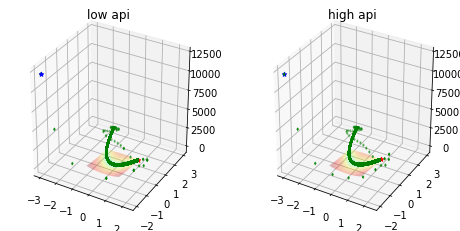

In [6]:
# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)

# 시각화 코드 
steps = [step, step_api] 
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
fetch_list = [[steps[0], xy_low],[steps[1], xy]]

for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    # v_history = []
    for i in range(15000):
        # _, xy_, v_ = sess.run([steps[ind], xy, v])
        _, xy_= sess.run(fetch_list[ind])
        xy_history.append(xy_)
        #v_history.append(v_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0], ys=xy_history[:, 1], zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()

## 문제 2 :  Momentum with NAG 구현하기 

---
1. tensoerflow 의 high level api 을 이용해 구현해 봅니다. 
2. tensoerflow 의 api 인 tf.gradients 을 이용해 직접 구현해 봅니다. 

3. 1, 2 번을 수행한 후  아래와 그림과 같이 `직접 구현한것`과 `tnesorflow high level api` 을 이용해 나온 그래프를 비교해주세요
![Imgur](https://i.imgur.com/5n6PBe9.png)
---


In [0]:
beta = 0.9
lr = 0.00005

In [0]:
# Low Level
x_low = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x_low')
y_low = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y_low')
xy_low = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy_low')
vt_x = tf.Variable(initial_value=tf.constant(0.), dtype=tf.float32, name='vt_x')
vt_y = tf.Variable(initial_value=tf.constant(0.), dtype=tf.float32, name='vt_y')

delta_x = x_low - beta * vt_x  #잘못된 Vt를 쓰는것 같다.
delta_y = y_low - beta * vt_y
#delta_x = tf.subtract(x_low, tf.multiply(beta, vt_x)) # x - mo* vt_x  # momentum is beta
# delta_y = tf.subtract(y_low, tf.multiply(beta, vt_y))
        
z_low = rosenbrock(delta_x, delta_y)
z_low = tf.identity(z_low, name='z_low')

# Get Gradient
d_x, d_y = tf.gradients(z_low, [delta_x, delta_y], name='gradients')    # y 가 x 에 대한 함수가 아니면 gradients 는 None 이 나옵니다. # tensor의 list의 괄호 하나 풀기

# momentum
vt_x_assign = tf.assign(vt_x, (beta * vt_x) + d_x)
vt_y_assign = tf.assign(vt_y, (beta * vt_y) + d_y)

# update
x_assign = tf.assign_sub(x_low, lr * vt_x_assign) 
y_assign = tf.assign_sub(y_low, lr * vt_y_assign)

xy_assgin = tf.assign(xy_low, tf.stack([x_low, y_low], axis=0))
  #  xy: [-3. -2.] d_x: -13208.0 d_y: -2200.0 delta_x: -3.0 vt_x: 0.0
                        
step = tf.group( [x_assign, y_assign, xy_assgin], name='step' ) # group에는 []로 처리해야한다!!
tf.add_to_collection(tf.GraphKeys.TRAIN_OP, step)

In [0]:
# High Level          
x = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x')
y = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y')

z = rosenbrock(x, y)
z = tf.identity(z, name='z')

# Memory Moving position
xy = tf.stack([x, y], axis=0)

# Train
step_api = tf.train.MomentumOptimizer(lr, momentum=beta, use_nesterov=True).minimize(z)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in square
  # Remove the CWD from sys.path while we load stuff.


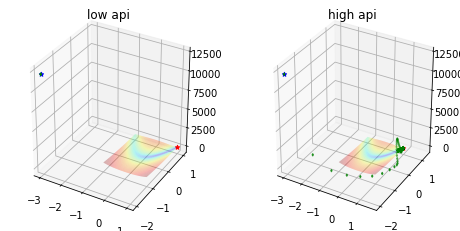

In [22]:
# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)


# 시각화 코드 
steps = [step, step_api] 
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
# fetch_list = [[steps[0], xy_low, vt_x, d_x, d_y, delta_x, delta_y],[steps[1], xy]]
fetch_list = [[steps[0], xy_low],[steps[1], xy]]

for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    # v_history = []
    for i in range(15000):
        # _, xy_, v_ = sess.run([steps[ind], xy, v])
        # _, xy_, vt_x_, d_x_, d_y_, delta_x_, delta_y_ = sess.run(fetch_list[ind])
        _, xy_= sess.run(fetch_list[ind])
        xy_history.append(xy_)
        # print("xy:", xy_, "d_x:", d_x_, "d_y:", d_y_, "delta_x:", delta_x_, "vt_x:", vt_x_)
        #v_history.append(v_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0], ys=xy_history[:, 1], zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()

## 문제 3 : RMSProp 구현하기 

---
1. tensoerflow 의 high level api 을 이용해 구현해 봅니다. 
2. tensoerflow 의 api 인 tf.gradients 을 이용해 직접 구현해 봅니다. 

3. 1, 2 번을 수행한 후  아래와 그림과 같이 `직접 구현한것`과 `tnesorflow high level api` 을 이용해 나온 그래프를 비교해주세요
![Imgur](https://i.imgur.com/zTrVlhH.png)
---


In [0]:
lr = 0.05
esp = 1e-10
beta = 0.9

In [0]:
# Low Level
x_low = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x_low')
y_low = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y_low')
xy_low = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy_low')

z_low = rosenbrock(x_low, y_low)
z_low = tf.identity(z_low, name='z_low')

# Get Gradient
d_x, d_y = tf.gradients(z_low, [x_low, y_low], name='gradients')  # y 가 x 에 대한 함수가 아니면 gradients 는 None 이 나옵니다.

# learing rate
gt_x = tf.Variable(0, dtype=tf.float32, name='gt_x')
gt_y = tf.Variable(0, dtype=tf.float32, name='gt_y')
gt_x_assign = tf.assign(gt_x, (1-beta)*gt_x + beta*(d_x)**2)
gt_y_assign = tf.assign(gt_y, (1-beta)*gt_y + beta*(d_y)**2)

# update
x_assign = tf.assign_sub(x_low, lr / tf.sqrt(gt_x_assign + esp) * d_x)
y_assign = tf.assign_sub(y_low, lr / tf.sqrt(gt_y_assign + esp) * d_y)
xy_assgin = tf.assign(xy_low, tf.stack([x_low, y_low], axis=0))
    
step = tf.group( [x_assign, y_assign, xy_assgin], name='step' ) # group에는 []로 처리해야한다!!

In [0]:
# High Level          
x = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x')
y = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y')

z = rosenbrock(x, y)
z = tf.identity(z, name='z')

# Memory Moving position
xy = tf.stack([x, y], axis=0)

# Train
step_api = tf.train.RMSPropOptimizer(lr, decay=beta, epsilon=esp).minimize(z)      

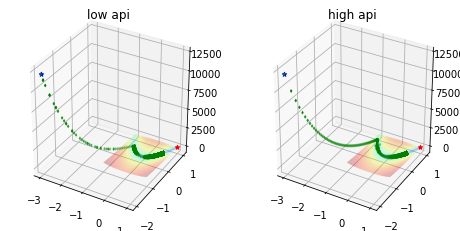

In [14]:
# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)

# 시각화
steps = [step, step_api] 
fetch_list = [[steps[0], xy_low],[steps[1], xy]]
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    #g_history = []
    for i in range(80000):
        _, xy_ = sess.run(fetch_list[ind]) # _, xy_, g_ = sess.run([steps[ind], xy, g])
        xy_history.append(xy_)
        # g_history.append(g_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0],
               ys=xy_history[:, 1],
               zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()

## 문제 4 : Adam 구현하기 

---
1. tensoerflow 의 high level api 을 이용해 구현해 봅니다. 
2. tensoerflow 의 api 인 tf.gradients 을 이용해 직접 구현해 봅니다. 

3. 1, 2 번을 수행한 후  아래와 그림과 같이 `직접 구현한것`과 `tnesorflow high level api` 을 이용해 나온 그래프를 비교해주세요

4. 왜 결과가 다르게 나오는지 이유를 설명해 보세요.
![Imgur](https://i.imgur.com/55j23aw.png)
---


In [0]:
lr = 0.1
esp = 1e-8
beta_v = 0.9 # beta 1
beta_g = 0.999 # beta 2

In [0]:
# Low Level
x_low = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x_low')
y_low = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y_low')
xy_low = tf.Variable(initial_value=start_xy, dtype=tf.float32, name='xy_low')

z_low = rosenbrock(x_low, y_low)
z_low = tf.identity(z_low, name='z_low')

# Get Gradient
d_x, d_y = tf.gradients(z_low, [x_low, y_low], name='gradients')  # y 가 x 에 대한 함수가 아니면 gradients 는 None 이 나옵니다.

# learning rate
gt_x = tf.Variable(0, dtype=tf.float32, name='gt_x')
gt_y = tf.Variable(0, dtype=tf.float32, name='gt_y')
gt_x_assign = tf.assign(gt_x, (1-beta_v)*gt_x + beta_v*(d_x)**2)
gt_y_assign = tf.assign(gt_y, (1-beta_v)*gt_y + beta_v*(d_y)**2)

# momentum
vt_x = tf.Variable(0, dtype=tf.float32, name='vt_x')
vt_y = tf.Variable(0, dtype=tf.float32, name='vt_y')
vt_x_assign = tf.assign(vt_x, (1-beta_g)*vt_x + beta_g*(d_x))
vt_y_assign = tf.assign(vt_y, (1-beta_g)*vt_y + beta_g*(d_y))

# update
x_assign = tf.assign_sub(x_low, lr / tf.sqrt(gt_x_assign + esp) * vt_x_assign)
y_assign = tf.assign_sub(y_low, lr / tf.sqrt(gt_y_assign + esp) * vt_y_assign)
xy_assgin = tf.assign(xy_low, tf.stack([x_low, y_low], axis=0))
    
step = tf.group( [x_assign, y_assign, xy_assgin], name='step' ) # group에는 []로 처리해야한다!!

In [0]:
# High Level          
x = tf.Variable(initial_value=tf.constant(start_x), dtype=tf.float32, name='x')
y = tf.Variable(initial_value=tf.constant(start_y), dtype=tf.float32, name='y')

z = rosenbrock(x, y)
z = tf.identity(z, name='z')

# Memory Moving position
xy = tf.stack([x, y], axis=0)

# Train
step_api = tf.train.AdamOptimizer(lr, beta1=beta_v, beta2=beta_g, epsilon=esp).minimize(z)      

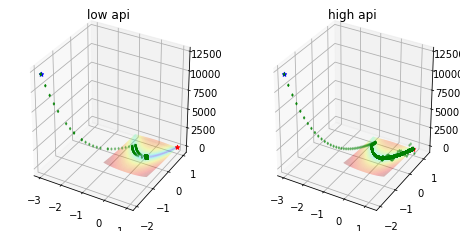

In [18]:
# xy coordinate with z : 좌표 grid 을 생성합니다.
x, y = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
z = rosenbrock(x, y)

# 시각화
steps = [step, step_api] 
fetch_list = [[steps[0], xy_low],[steps[1], xy]]
titles = ['low api', 'high api'] 
fig = plt.figure(figsize=plt.figaspect(0.5))
for ind in range(2):
    ax = fig.add_subplot(1,2,ind+1,projection='3d')
    # plot start point 
    ax.plot_surface(x, y, z, cmap=plt.cm.jet, alpha=0.3, norm=LogNorm())
    ax.scatter(xs=min_x, ys=min_y, marker='*', color='r')
    ax.scatter(xs=start_x, ys=start_y, zs=rosenbrock(-3, -2), marker='*', color='b')

    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    xy_history = []
    # g_history = []
    for i in range(15000):
        _, xy_ = sess.run(fetch_list[ind]) # _, xy_, g_ = sess.run([steps[ind], xy, g])
        xy_history.append(xy_)
        # g_history.append(g_)
    xy_history = np.stack(xy_history, axis=0)
    ax.scatter(xs=xy_history[:, 0],
               ys=xy_history[:, 1],
               zs=rosenbrock(xy_history[:, 0], xy_history[:, 1]),
               marker='d', color='g', s=3)
    ax.set_title(titles[ind])
plt.show()

#  

<hr>
<div style = "background-image: url('https://algorithmai.io/static/media/logo.665798c4.png');background-repeat: no-repeat; background-position: right; background-size: 220px 40px; padding : 5px 10px 5px 5px;">
    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, Kim Seong Jung( plznw4me@publicai.co.kr )  last updated on 2019/04/17
</div>
<hr>